##**Asssignment2-PART-B-Section2-Dialogue Act Tagging**

**NAME :** Ganesh Kumaran Masilamani

**STUDENT ID :** 200434339


In [1]:
!pip install tensorflow-gpu==2.4.1

     |████████████████████████████████| 394.3MB 37kB/s 


In [1]:
#libraries imported
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
!wget http://compprag.christopherpotts.net/code-data/swda.zip
!unzip swda.zip

--2021-04-14 01:59:21--  http://compprag.christopherpotts.net/code-data/swda.zip
Resolving compprag.christopherpotts.net (compprag.christopherpotts.net)... 64.90.36.20
Connecting to compprag.christopherpotts.net (compprag.christopherpotts.net)|64.90.36.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14040987 (13M) [application/zip]
Saving to: ‘swda.zip’

swda.zip            100%[===================>]  13.39M  8.58MB/s    in 1.6s    

2021-04-14 01:59:23 (8.58 MB/s) - ‘swda.zip’ saved [14040987/14040987]

Archive:  swda.zip
   creating: swda/
  inflating: swda/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/swda/
  inflating: __MACOSX/swda/._.DS_Store  
   creating: swda/sw00utt/
  inflating: swda/sw00utt/sw_0001_4325.utt.csv  
   creating: __MACOSX/swda/sw00utt/
  inflating: __MACOSX/swda/sw00utt/._sw_0001_4325.utt.csv  
  inflating: swda/sw00utt/sw_0002_4330.utt.csv  
  inflating: swda/sw00utt/sw_0003_4103.utt.csv  
  inflating: swda/sw00ut

In [2]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [5]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [3]:
reduced_df = result[['act_tag','text']]


Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [4]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [5]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


To get unique tags:

In [6]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [7]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [8]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create utterance representations as sequences of words:

In [9]:
utterances = []
for i in range(0, len(reduced_df)):
    utterances.append(reduced_df['text'].iloc[i].split(" "))


In [10]:
wordvectors = {}
index = 1
for u in utterances:
    for w in u:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [11]:
# Max length of 137
MAX_LENGTH = len(max(utterances, key=len))

In [12]:
utterance_embeddings = []
for u in utterances:
    utterance_emb = []
    for w in u:
        utterance_emb.append(wordvectors[w])
    utterance_embeddings.append(utterance_emb)


Then we split the dataset into test and train.

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(utterance_embeddings, np.array(tags_encoding))

And pad the utterances with zero to make all utterances of equal length.


In [14]:
MAX_LENGTH = 137

In [15]:
from keras.preprocessing.sequence import pad_sequences
 
train_utterances_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_utterances_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [16]:
#Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training
train_input = train_utterances_X[:140000]
val_input = train_utterances_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]

#**Model 1**

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get the probabilities.


In [17]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(utterances, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [18]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states
model = Sequential()
#layer1 --> Embedding layer
model.add(Embedding(VOCAB_SIZE+1,100, input_length=MAX_LENGTH))
#layer2 --> Bidirectional1 layer
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
#layer3 --> Bidirectional2 layer
model.add(Bidirectional(LSTM(HIDDEN_SIZE)))
#layer4 --> Dense layer
model.add(Dense(HIDDEN_SIZE, activation='relu'))
#layer5 --> Activation layer
model.add(Activation('softmax'))

#compile the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional (Bidirectional (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense (Dense)                (None, 43)                3741      
_________________________________________________________________
activation (Activation)      (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train the model - using validation 
history_model1= model.fit(x=train_input, y=train_labels, validation_data=(val_input,val_labels), epochs=10, verbose=1, batch_size=1000)

Epoch 1/10
140/140 [==============================] - 25s 140ms/step - loss: 3.2037 - accuracy: 0.2026 - val_loss: 1.5559 - val_accuracy: 0.6037
Epoch 2/10
140/140 [==============================] - 18s 130ms/step - loss: 1.4461 - accuracy: 0.6258 - val_loss: 1.3531 - val_accuracy: 0.6485
Epoch 3/10
140/140 [==============================] - 18s 130ms/step - loss: 1.2546 - accuracy: 0.6730 - val_loss: 1.2902 - val_accuracy: 0.6592
Epoch 4/10
140/140 [==============================] - 18s 130ms/step - loss: 1.1401 - accuracy: 0.7071 - val_loss: 1.2179 - val_accuracy: 0.6776
Epoch 5/10
140/140 [==============================] - 18s 130ms/step - loss: 1.0531 - accuracy: 0.7353 - val_loss: 1.2188 - val_accuracy: 0.6815
Epoch 6/10
140/140 [==============================] - 18s 129ms/step - loss: 0.9861 - accuracy: 0.7534 - val_loss: 1.2178 - val_accuracy: 0.6834
Epoch 7/10
140/140 [==============================] - 18s 129ms/step - loss: 0.9484 - accuracy: 0.7623 - val_loss: 1.2036 - val_ac

In [20]:
#evaluate on test data
score = model.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 9s 16ms/step - loss: 1.2042 - accuracy: 0.6859


In [21]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 68.58967542648315


In [22]:
pip install plot_keras_history

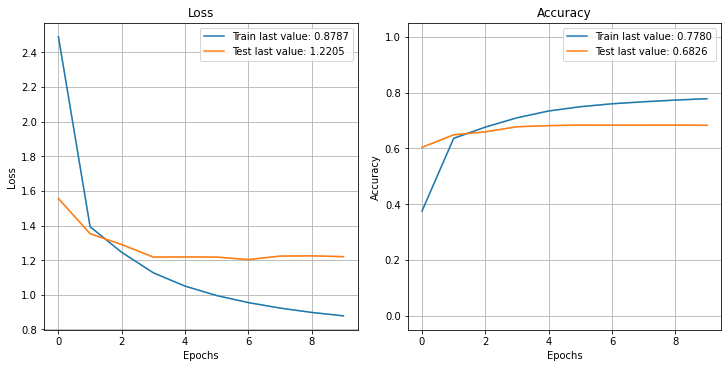

In [23]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

#plotting
plot_history(history_model1.history, path="standard.png")
plt.show()

###Evaluation:

*Accuracy for the model1* -- **68.58967542648315**

The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [24]:
# Generate predictions for the test data
predictions = model.predict(test_utterances_X)

In [25]:
# Build the confusion matrix off these predictions
Confusion_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(Confusion_matrix)

[[  0   0   0 ...   0   0   2]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   2]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0 940]]


In [26]:
Classification_report = sklearn.metrics.classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(Classification_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00       197
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        67
           5       0.53      0.71      0.61       497
           6       0.00      0.00      0.00        29
           7       0.81      0.77      0.79      3916
           8       0.48      0.66      0.56       305
           9       0.00      0.00      0.00        69
          10       0.69      0.66      0.67      1148
          11       0.72      0.84      0.77     19040
          12       0.00      0.00      0.00       242
          13       0.91      0.96      0.93       955
          14       0.00      0.00      0.00       174
          15       0.53      0.62      0.57      1183
          16       0.00      0.00      0.00       773
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Calculate Accuracies for "br" and "bf"
bf_index = 16
br_index = 19
print("Summarization Accuracy:{}".format(Confusion_matrix[bf_index][bf_index]/sum(Confusion_matrix[bf_index])))
print("Signal NU Accuracy:{}".format((Confusion_matrix[br_index][br_index]/sum(Confusion_matrix[br_index]))))

Summarization Accuracy:0.0
Signal NU Accuracy:0.0


* Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. 
* The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




#**Model 2 - Balanced Network**


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight the loss function in training, to weight up the minority classes proportionally to their underrepresentation. 

In [28]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [29]:
# Re-built the model for the balanced training
model_balanced = Sequential()
#layer1 --> Embedding layer
model_balanced.add(Embedding(VOCAB_SIZE+1,100, input_length=MAX_LENGTH))
#layer2 --> Bidirectional1 layer
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
#layer3 --> Bidirectional2 layer
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE)))
#layer4 --> Dense layer
model_balanced.add(Dense(HIDDEN_SIZE, activation='relu'))
#layer5 --> Activation layer
model_balanced.add(Activation('softmax'))

#compile the model
model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_balanced.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_1 (Activation)    (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the balanced network -  takes  time to achieve good accuracy
history_model2 =model_balanced.fit(x=train_input, y=train_labels, validation_data=(val_input,val_labels), epochs=30, verbose=1, class_weight=d_class_weights, batch_size=1000)

Epoch 1/30
140/140 [==============================] - 23s 139ms/step - loss: 3.7152 - accuracy: 0.1288 - val_loss: 2.9232 - val_accuracy: 0.2997
Epoch 2/30
140/140 [==============================] - 19s 133ms/step - loss: 3.2428 - accuracy: 0.3357 - val_loss: 2.5376 - val_accuracy: 0.4074
Epoch 3/30
140/140 [==============================] - 19s 133ms/step - loss: 2.7724 - accuracy: 0.3516 - val_loss: 2.4194 - val_accuracy: 0.3503
Epoch 4/30
140/140 [==============================] - 19s 133ms/step - loss: 2.4413 - accuracy: 0.3757 - val_loss: 2.2324 - val_accuracy: 0.3827
Epoch 5/30
140/140 [==============================] - 19s 133ms/step - loss: 2.0903 - accuracy: 0.4164 - val_loss: 2.2680 - val_accuracy: 0.3872
Epoch 6/30
140/140 [==============================] - 19s 133ms/step - loss: 1.9714 - accuracy: 0.4419 - val_loss: 2.2538 - val_accuracy: 0.3684
Epoch 7/30
140/140 [==============================] - 19s 133ms/step - loss: 1.7748 - accuracy: 0.4502 - val_loss: 2.1726 - val_ac

## Test the model

In [31]:
#Overall Accuracy
score = model_balanced.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 9s 16ms/step - loss: 1.8397 - accuracy: 0.4765


In [32]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 47.65303432941437


In [33]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_utterances_X, batch_size=100)

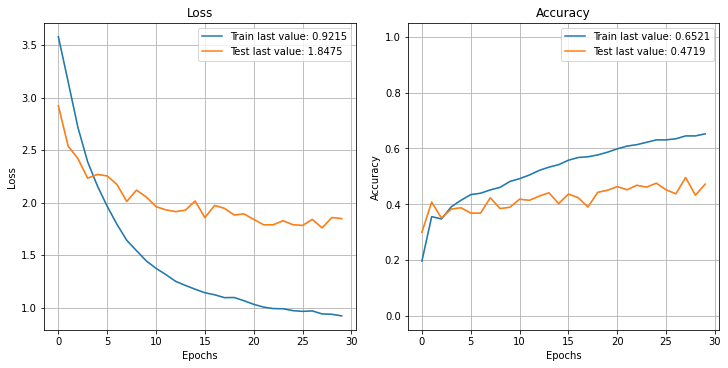

In [34]:
plot_history(history_model2.history, path="standard.png")
plt.show()

##**Balanced network evaluation**

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [35]:
# Build the confusion matrix off these predictions
matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
print(matrix_balanced)
balanced_classification_report = sklearn.metrics.classification_report(y_test.argmax(axis=1), label_pred.argmax(axis=1))
print(balanced_classification_report)
# Calculate Accuracies for "br" and "bf"
bf_index = 16
br_index = 19
print('Summarization Accuracy: {}'.format(matrix_balanced[bf_index][bf_index]/sum(matrix_balanced[bf_index])))
print('Signal NU Accuracy: {}'.format((matrix_balanced[br_index][br_index]/sum(matrix_balanced[br_index]))))


[[   7    1    0 ...    0    0    1]
 [  12 5843    8 ...   66    1    3]
 [   4    0   37 ...    0    1    1]
 ...
 [   0    1    2 ...   13    0    0]
 [   1    0    2 ...    0   16    4]
 [  19    1    2 ...    1   54 2869]]
              precision    recall  f1-score   support

           0       0.03      0.24      0.05        29
           1       0.91      0.61      0.73      9503
           2       0.21      0.69      0.32        54
           3       0.13      0.46      0.20       328
           4       0.04      0.13      0.06       180
           5       0.59      0.60      0.60      4752
           6       0.27      0.70      0.39       322
           7       0.59      0.44      0.51      1208
           8       0.05      0.21      0.08        29
           9       0.43      0.53      0.47       638
          10       0.53      0.81      0.64       270
          11       0.00      0.00      0.00        21
          12       0.20      0.69      0.31       301
          13   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##**Inference:**
*Overall Accuracy* -- **47.65303432941437**

*bf class Accuracy* -- **0.0851063829787234**

*br class Accuracy* -- **0.65**
###**Other ways to handle imbalanced classes:**

* Samples are removed from the majority classes to balance out the inbalanced classes in the dataset.
* Generative models are used to produce samples of the minority classes.
* with the help of these minority classes, imbalanced datasets gets balanced out.
* Training dataset can be resampled.

#**Model 3 - Using Context for Dialog Act Classification**

##**CNN Model**

In [28]:
from keras.layers import Input
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPool2D
from keras.layers import Concatenate
from keras.layers import Flatten
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(utterances, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

#CNN model
#layer1 --> Input layer
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
#layer2 --> Embedding layer
embedding = Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions layers
#layer3 --> first convolutional layer with batch normalization
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
#layer4 --> second convolutional layer with batch normalization
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
#layer5 --> third convolutional layer with batch normalization
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

#maxpool for 3 layers
#layer6 --> maxpooling layer to merge with three batchnormalization layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

#layer7 --> concatenate the tensors
concate = Concatenate()([maxpool_0, maxpool_1, maxpool_2])
#layer8 --> flatten concatenated tensors
flat1 = TimeDistributed(Flatten())(concate)
#layer9 --> dense layer (dense_1)
shape = np.shape(flat1)
dense_1 = Dense(100, activation='relu')(flat1)
#layer10 --> first dropout layer
dropout_1 = Dropout(drop)(dense_1)

If you want CNN layers to interact with the LSTM layer, they need to be distributed across time.

##**BLSTM Model**


In [29]:
#BLSTM model
#layer11 --> first Bidirectional layer
dshape = np.shape(dropout_1)
bidirectional_1 = Bidirectional(LSTM(100, return_sequences=True))(dropout_1)
#layer12 --> second Bidirectional layer
b1shape = np.shape(bidirectional_1)
bidirectional_2 = Bidirectional(LSTM(100))(bidirectional_1)
#layer13 --> second Dense layer
b2shape = np.shape(bidirectional_2)
dense_2 = Dense(100, activation='relu')(bidirectional_2)
#layer14 --> second dropout layer
dropout_2 = Dropout(drop)(dense_2)

Concatenate 2 last layers and create the output layer. You need to concatenate the outputs of CNN and LSTM (dropout_1 and dropout_2)

In [30]:
from keras.models import Model
#layer15 --> concatenate the final two layers
dropout_1_shape = Flatten()(dropout_1)
final_concate = Concatenate()([dropout_1_shape,dropout_2])
#layer16 --> output layer
output = Dense(43, activation='relu')(final_concate)
cnn_model = Model(inputs=[inputs], outputs=[output])

#compile the model
cnn_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 137)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 137, 100)     4373200     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 137, 100, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 135, 1, 64)   19264       reshape[0][0]                    
______________________________________________________________________________________________

In [31]:
# Train the model - using validation 
history_model3 = cnn_model.fit(x=train_input, y=train_labels, validation_data=(val_input,val_labels), epochs=10, verbose=1, batch_size=1000)

Epoch 1/10
140/140 [==============================] - 18s 97ms/step - loss: 3.3403 - accuracy: 0.4501 - val_loss: 2.2544 - val_accuracy: 0.5502
Epoch 2/10
140/140 [==============================] - 12s 89ms/step - loss: 2.0148 - accuracy: 0.5722 - val_loss: 1.9902 - val_accuracy: 0.5592
Epoch 3/10
140/140 [==============================] - 12s 89ms/step - loss: 1.8051 - accuracy: 0.6066 - val_loss: 1.8254 - val_accuracy: 0.6187
Epoch 4/10
140/140 [==============================] - 12s 89ms/step - loss: 1.7240 - accuracy: 0.6582 - val_loss: 1.9260 - val_accuracy: 0.6101
Epoch 5/10
140/140 [==============================] - 12s 89ms/step - loss: nan - accuracy: 0.6627 - val_loss: 1.8141 - val_accuracy: 0.6340
Epoch 6/10
140/140 [==============================] - 12s 89ms/step - loss: 1.5867 - accuracy: 0.6948 - val_loss: 1.8381 - val_accuracy: 0.6538
Epoch 7/10
140/140 [==============================] - 12s 88ms/step - loss: nan - accuracy: 0.7170 - val_loss: 2.0469 - val_accuracy: 0.592

In [32]:
#evaluate on test data
score = cnn_model.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 3s 5ms/step - loss: 1.8609 - accuracy: 0.6656


In [33]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 66.56291484832764


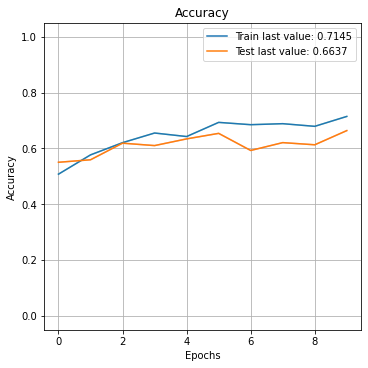

In [34]:
plot_history(history_model3.history, path="standard.png")
plt.show()

Report your overall accuracy and the minority class accuracies. Discuss whether context helped disambiguate and better predict the minority classes ('br' and 'bf'). What are some frequent errors? Show one positive example where adding context changed the prediction.




In [46]:
CNN_Confusion_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
print(CNN_Confusion_matrix)
bf_index = 16
br_index = 19
# Calculate Accuracies for "br" and "bf"
print('Summarization Accuracy: {}'.format(CNN_Confusion_matrix[bf_index][bf_index]/sum(CNN_Confusion_matrix[bf_index])))
print('Signal NU Accuracy: {}'.format((CNN_Confusion_matrix[br_index][br_index]/sum(CNN_Confusion_matrix[br_index]))))

[[   7    1    0 ...    0    0    1]
 [  12 5843    8 ...   66    1    3]
 [   4    0   37 ...    0    1    1]
 ...
 [   0    1    2 ...   13    0    0]
 [   1    0    2 ...    0   16    4]
 [  19    1    2 ...    1   54 2869]]
Summarization Accuracy: 0.0851063829787234
Signal NU Accuracy: 0.65


##**Inference:**
*Overall Accuracy* -- **66.56291484832764**

*bf class Accuracy* -- **0.0851063829787234**

*br class Accuracy* -- **0.65**

**Discussion:**
Yes, Context helped disambiguate and better predict the minority classes, in which classes are summarized and the accuracy is calculated.

**Some frequent errors:**
* Imbalanced classes is specifically hard to classsify because of the complexity of skewed class distribution. 
* The difficulty of imbalanced class can be because of data size, latent noise, and data split and distribution.

**One positive example where adding context changed the prediction**
* In sentiment analysis, excellent is positive outcome, its okay is the neutral outcome and the poor is the negative outcome.
